In [27]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import Image
from PIL import Image
import io
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [28]:
# Mount to Google Drive so images in Drive can be accessed by Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Read CSV file that contains corresponding item data
data = pd.read_csv('depop_item_details_complete.csv')
data = data.drop(columns=['Image', 'Date', 'Location'])
data.head()

,Description,Price listed,Price sold,Size,Brand
0,🌫️ Vintage hot pink sweater 🌫️ ▫️ Stretchy hot...,US$20.00,US$11.00,M,Cache
1,🌫️ Wool pencil skirt 🌫️ ▫️ Grey wool fabric sh...,US$15.00,US$4.50,4,Ralph Lauren
2,🌫️ Green and Black corset🌫️ ▫️ Gorge iridescen...,US$14.00,US$7.00,30,Other
3,🌫️ Vintage denim mini skirt 🌫️ ▫️ Lighter weig...,US$20.00,US$6.00,6,Calvin Klein
4,🌫️ Wide leg y2k pants 🌫️ ▫️ Thick black fabric...,US$20.00,US$14.00,8,American Vintage


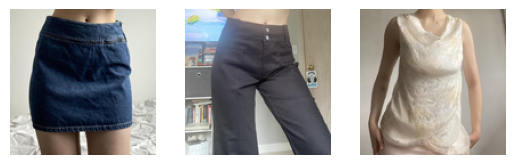

In [30]:
# Show example images to check format and quality
indices = np.array(data.index)
plt.figure()
# For each image, retrieve RGB matrix from Google Drive
for i in indices[3:6]:

    # Open the JPEG file
    rgb_matrix = np.load("/content/drive/MyDrive/depop_images/depop_image_" + str(i) + ".npy")

    # Change image to PIL format for in-cell display
    image = Image.fromarray(np.uint8(rgb_matrix))

    # Display the image in the notebook
    plt.subplot(1, 3, i-2)
    plt.imshow(image)
    plt.axis('off')

In [31]:
# Prices pulled from Depop are strings and have undesired 'US$', let's change them to floats for easier calculations
def pricing(price):
    """
    Reformat scraped Depop prices to floats.

    Parameters:
    price (string): Price string from Depop.

    Returns:
    price (float): Price as a float.
    """
    try:
      return float(price.replace('US$', ''))

    except ValueError:
      return price

# Apply pricing function
data['Price listed'] = data['Price listed'].apply(pricing)
data['Price sold'] = data['Price sold'].apply(pricing)

In [32]:
# Sizes pulled from Depop vary too greatly to be useful to NN, so we implement a simple sizing scheme
def sizing(size):
    """
    Find and replace numbered sizing (in womens clothing) and replace values with more discrete sizing scheme.

    Parameters:
    size (string): Raw size string from Depop.

    Returns:
    size (string): Size string converted in scheme.
    """
    try:
      # If size is number, it can be converted into a float, and therefore needs a category defined by the scheme below
      size = float(size)
      if size <= 4:
        return 'XS'

      elif size <= 8 or size == 26: # Note, the 26 is accounting for a pair of jeans in my particular dataset
        return 'S'

      elif size <= 12:
        return 'M'

      elif size <= 16 or size == 30: # Note, the 30 is accounting for a corset in my particular dataset
        return 'L'

      else:
        return 'XL'

    except ValueError:
      # If size isn't a number and contains 'US', it is a shoe
      # Handling this under scheme for now, but should potentially be changed to cater towards shoes (rather than clothing)
      if 'US ' in size:
        size = size.replace('US ', '')

        try:
          return sizing(float(size))

        except ValueError:
          return size

      else:
        return size

# Apply sizing function
data['Size'] = data['Size'].apply(sizing)

In [33]:
# Define transform function to convert image to tensor of proper dimensions
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Initialize input_images array to store RGB matrices
input_images = []

# Load each RGB matrix and add to input_images array
for i in indices:
  rgb_matrix = np.load("/content/drive/MyDrive/depop_images/depop_image_" + str(i) + ".npy")
  input_images.append(transform(rgb_matrix))

# Add Image column to data
data['Image'] = input_images

In [34]:
# Convert descriptions to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
description_vectors = vectorizer.fit_transform(data['Description'])

# Convert the sparse matrix to a dense format (e.g., numpy array)
description_vectors = description_vectors.toarray()

# Add the vectors to the DataFrame
data['Description'] = list(description_vectors)

In [35]:
# Scale Price listed values to help neural network
scaler = StandardScaler()
data['Price listed'] = scaler.fit_transform(data['Price listed'].values.reshape(-1, 1))

# Perform one-hot encoding on Size and Brand columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform size and brand columns
encoded_features = encoder.fit_transform(data[['Size', 'Brand']])

# Convert the encoded features into a DataFrame and concatenate with the original DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Size', 'Brand']))

# Concatenate the encoded columns with the original data (dropping the old categorical columns)
data = pd.concat([data.drop(['Size', 'Brand'], axis=1), encoded_df], axis=1)

# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=20)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=20)

# Verify dimensions of each dataset
print("Dimensions of train data: ", train_data.shape)
print("Dimensions of validation data: ", val_data.shape)
print("Dimensions of test data: ", test_data.shape)

Dimensions of train data:  (355, 165)
Dimensions of validation data:  (40, 165)
Dimensions of test data:  (99, 165)


In [36]:
# Define dataset
class DepopDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

        # Extract Size and Brand columns
        self.size_columns = [col for col in dataframe.columns if 'Size' in col]
        self.brand_columns = [col for col in dataframe.columns if 'Brand' in col]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Extract image, description, and numerical data
        image = self.dataframe['Image'].iloc[idx]  # Already a tensor
        description = torch.tensor(self.dataframe['Description'].iloc[idx], dtype=torch.float32)
        price_listed = torch.tensor([self.dataframe['Price listed'].iloc[idx]], dtype=torch.float32)

        # Extract one-hot encoded size and brand columns
        size = torch.tensor(self.dataframe[self.size_columns].iloc[idx].values, dtype=torch.float32)
        brand = torch.tensor(self.dataframe[self.brand_columns].iloc[idx].values, dtype=torch.float32)

        # Concatenate all inputs together
        combined_input = torch.cat([image.view(-1), description.view(-1), price_listed, size, brand], dim=0)

        # Label is the price sold
        label = torch.tensor(self.dataframe['Price sold'].iloc[idx], dtype=torch.float32)


        return combined_input, label

In [89]:
# Create DataLoaders for train, validation, and test sets
train_dataset = DepopDataset(train_data)
val_dataset = DepopDataset(val_data)
test_dataset = DepopDataset(test_data)

batch_size = 20  # Adjust as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [119]:
# Initialize Training Loss and Validation Accuracy list
train_loss_list = []
val_accuracy_list = []

In [120]:
class DepopPriceCNN(nn.Module):
    def __init__(self):
        super(DepopPriceCNN, self).__init__()

        # CNN for image input (assuming 3-channel RGB input, 128x128 images)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_image_1 = nn.Sequential(
            nn.Linear(16 * 32 * 64, 256),   # Input size matches flattened image
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_image_2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        self.fc_description_1 = nn.Sequential(
            nn.Linear(1000, 256),   # Description input size from TF-IDF or tokenized embedding
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_description_2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_description_3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Fully connected layers for the non-image data (price, size, brand)
        self.fc_other_1 = nn.Sequential(
            nn.Linear(1 + 15 + 146, 128),  # Sizes and brands one-hot encoded, price as float
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_other_2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Final combined layers
        self.fc_combined_1 = nn.Sequential(
            nn.Linear(128 + 64 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_combined_2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2)   # 20% dropout
        )

        self.fc_combined_3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.fc_combined_4 = nn.Linear(32, 1)  # Output layer for price prediction

    def forward(self, image, description, other_features):
        # CNN for image
        x_image = self.conv1(image)
        x_image = self.conv2(x_image)
        x_image = x_image.view(x_image.size(0), -1)  # Flatten image features
        x_image = self.fc_image_1(x_image)
        x_image = self.fc_image_2(x_image)

        # Fully connected for description
        x_description = self.fc_description_1(description)
        x_description = self.fc_description_2(x_description)
        x_description = self.fc_description_3(x_description)

        # Fully connected for other numerical inputs (price, size, brand)
        x_other = self.fc_other_1(other_features)
        x_other = self.fc_other_2(x_other)

        # Combine all inputs
        x_combined = torch.cat([x_image, x_description, x_other], dim=1)

        # Final layers
        x_combined = self.fc_combined_1(x_combined)
        x_combined = self.fc_combined_2(x_combined)
        x_combined = self.fc_combined_3(x_combined)
        output = self.fc_combined_4(x_combined)

        return output

In [121]:
# Initialize the model, loss function, and optimizer
model = DepopPriceCNN()
criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Split the input into its components
        image = inputs[:, :128*128*3].view(-1, 3, 128, 128)
        description = inputs[:, 128*128*3:128*128*3+1000]
        other_features = inputs[:, 128*128*3+1000:]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(image, description, other_features)
        loss = criterion(outputs, labels.view(-1, 1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_image = val_inputs[:, :128*128*3].view(-1, 3, 128, 128)
            val_description = val_inputs[:, 128*128*3:128*128*3+1000]
            val_other_features = val_inputs[:, 128*128*3+1000:]

            val_outputs = model(val_image, val_description, val_other_features)
            val_loss_item = criterion(val_outputs, val_labels.view(-1, 1)).item()
            val_loss += val_loss_item
            val_accuracy_list.append(val_loss_item)

    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')


Epoch [1/20], Loss: 283.7454
Epoch [1/20], Validation Loss: 260.6227
Epoch [2/20], Loss: 256.5081
Epoch [2/20], Validation Loss: 222.7728
Epoch [3/20], Loss: 199.2727
Epoch [3/20], Validation Loss: 147.0317
Epoch [4/20], Loss: 118.2817
Epoch [4/20], Validation Loss: 94.5832
Epoch [5/20], Loss: 96.0426
Epoch [5/20], Validation Loss: 99.5351
Epoch [6/20], Loss: 95.4593
Epoch [6/20], Validation Loss: 89.7700
Epoch [7/20], Loss: 85.3285
Epoch [7/20], Validation Loss: 86.8484
Epoch [8/20], Loss: 89.2839
Epoch [8/20], Validation Loss: 85.9823
Epoch [9/20], Loss: 87.9850
Epoch [9/20], Validation Loss: 83.0948
Epoch [10/20], Loss: 84.1914
Epoch [10/20], Validation Loss: 80.7834
Epoch [11/20], Loss: 85.0350
Epoch [11/20], Validation Loss: 82.9790
Epoch [12/20], Loss: 79.3035
Epoch [12/20], Validation Loss: 80.8881
Epoch [13/20], Loss: 80.6881
Epoch [13/20], Validation Loss: 79.9837
Epoch [14/20], Loss: 81.2100
Epoch [14/20], Validation Loss: 79.1551
Epoch [15/20], Loss: 81.8939
Epoch [15/20], V

Text(0.5, 0, 'Epochs')

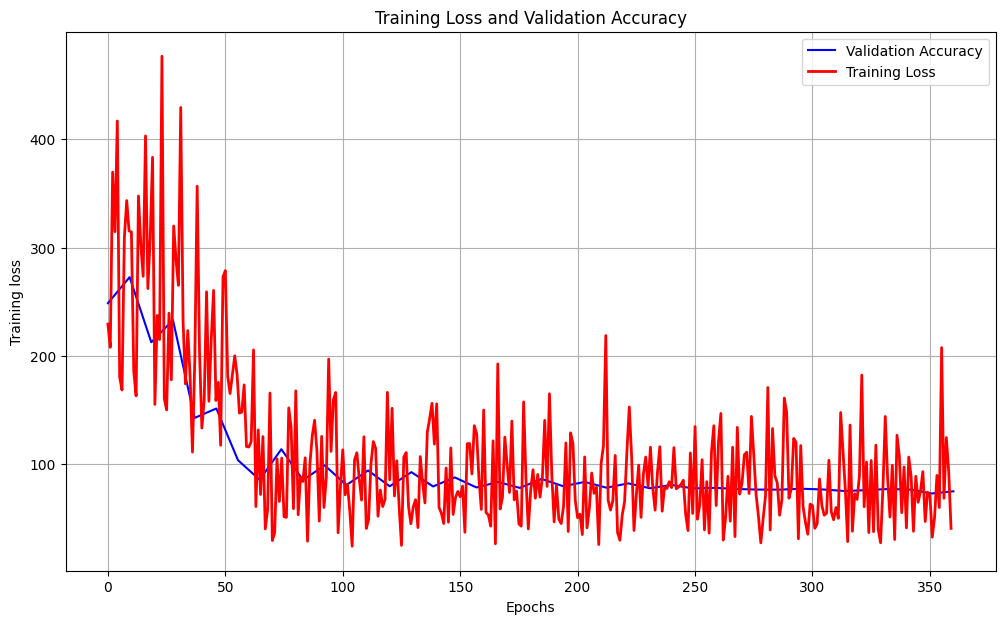

In [127]:
# Plots the training loss and validation accuracy
plt.figure(figsize = (12, 7))
plt.plot(np.linspace(0, 360, 40), val_accuracy_list, color = 'blue')
plt.plot(train_loss_list, linewidth = 2, color = 'red')
plt.legend(['Validation Accuracy', 'Training Loss'])
plt.title('Training Loss and Validation Accuracy')
plt.grid(True)
plt.ylabel("Training loss")
plt.xlabel("Epochs")

In [123]:
# Evaluation on the test set
model.eval()
test_loss = 0.0
predictions = []
actuals = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_image = test_inputs[:, :128*128*3].view(-1, 3, 128, 128)
        test_description = test_inputs[:, 128*128*3:128*128*3+1000]
        test_other_features = test_inputs[:, 128*128*3+1000:]

        test_outputs = model(test_image, test_description, test_other_features)
        test_loss += criterion(test_outputs, test_labels.view(-1, 1)).item()

        predictions.extend(test_outputs.view(-1).cpu().numpy())
        actuals.extend(test_labels.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 113.6375


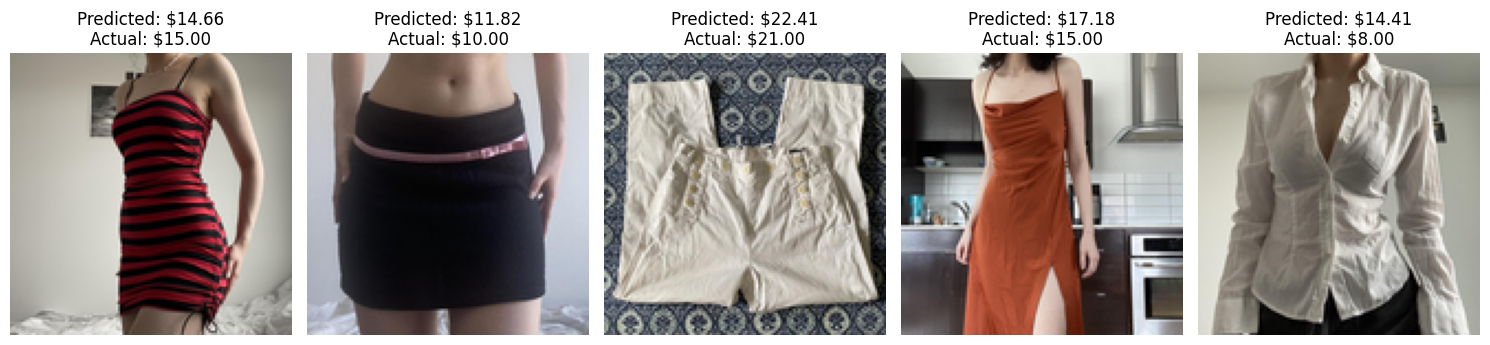

In [124]:
# Now we'll visualize model performance
num_samples = 5  # Adjust based on how many you want to see
real_values = actuals[-num_samples: ]
predicted_values = predictions[-num_samples: ]

# Define the mean and std values used for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Function to reverse normalization
def reverse_normalize(tensor):
    return tensor * std[:, None, None] + mean[:, None, None]

plt.figure(figsize=(15, 10))

for i, input  in enumerate(test_inputs[-num_samples:]):
    image_tensor = input[:128*128*3]  # Extract the features for the idx
    image = image_tensor.view(3, 128, 128)  # Reshape to (C, H, W)
    image = reverse_normalize(image)  # Apply reverse normalization
    actual_price = real_values[i].item()  # Ensure it's a scalar
    predicted_price = predicted_values[i].item()  # Ensure it's a scalar

    # Transpose to HxWxC for visualization
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert to HxWxC for plt.imshow

    # Plotting
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(image)  # Display the image
    plt.axis('off')  # Hide axes
    plt.title(f'Predicted: ${predicted_price:.2f}\nActual: ${actual_price:.2f}')  # Show prices

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [125]:
def calculate_mape(actuals, predictions):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Parameters:
    actuals (tensor): Actual prices (ground truth).
    predictions (tensor): Predicted prices by the model.

    Returns:
    mape (float): MAPE value as a percentage.
    """
    # Convert tensors to numpy arrays if needed
    actuals_np = actuals.cpu().numpy()
    predictions_np = predictions.cpu().numpy()

    # Avoid division by zero by adding a small constant where actuals are zero
    actuals_np = np.where(actuals_np == 0, 1e-10, actuals_np)

    # Calculate the percentage error
    percentage_errors = np.abs((actuals_np - predictions_np) / actuals_np) * 100

    # Calculate MAPE
    mape = np.mean(percentage_errors)

    return mape

In [126]:
calculate_mape(torch.tensor(actuals), torch.tensor(predictions))

74.18139